Our libraries and imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset analysis

In [2]:
df = pd.read_csv("NHANES_age_prediction.csv")
print(df.head())

df.info()

print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6

### Our Feature Engineering:
### Creating "Young" group and Dropping Age column
##### If we keep the age column in the dataet, models will using it to guess the answer, it leads to **data leakage** because these models seem pretty accurate at training but in real cases they will fail the performance on new data.

In [3]:
df['RIDAGEYR'] = df.apply(lambda row: 'Young' if 12 <= row['RIDAGEYR'] <= 25 else row['age_group'], axis=1)

df = df.drop('RIDAGEYR', axis=1)

### Transforming our dataset:
#### Renaming the columns for clearer understanding of data

In [4]:
df.rename(columns={
    'SEQN': 'ID',
    'RIAGENDR': 'gender',
    'PAQ605': 'physical_activity',
    'BMXBMI': 'bmi',
    'LBXGLU': 'glucose',
    'DIQ010': 'diabetes_status',
    'LBXGLT': 'glucose_tolerance',
    'LBXIN': 'insulin'
}, inplace=True)

#### Converting age_group into numeric value for future using

In [5]:
categories_order = [['Young', 'Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])


#### Splitting data into input features(X) and target variable(y).

In [6]:
X = df.drop(columns = 'age_group')
y = df['age_group']

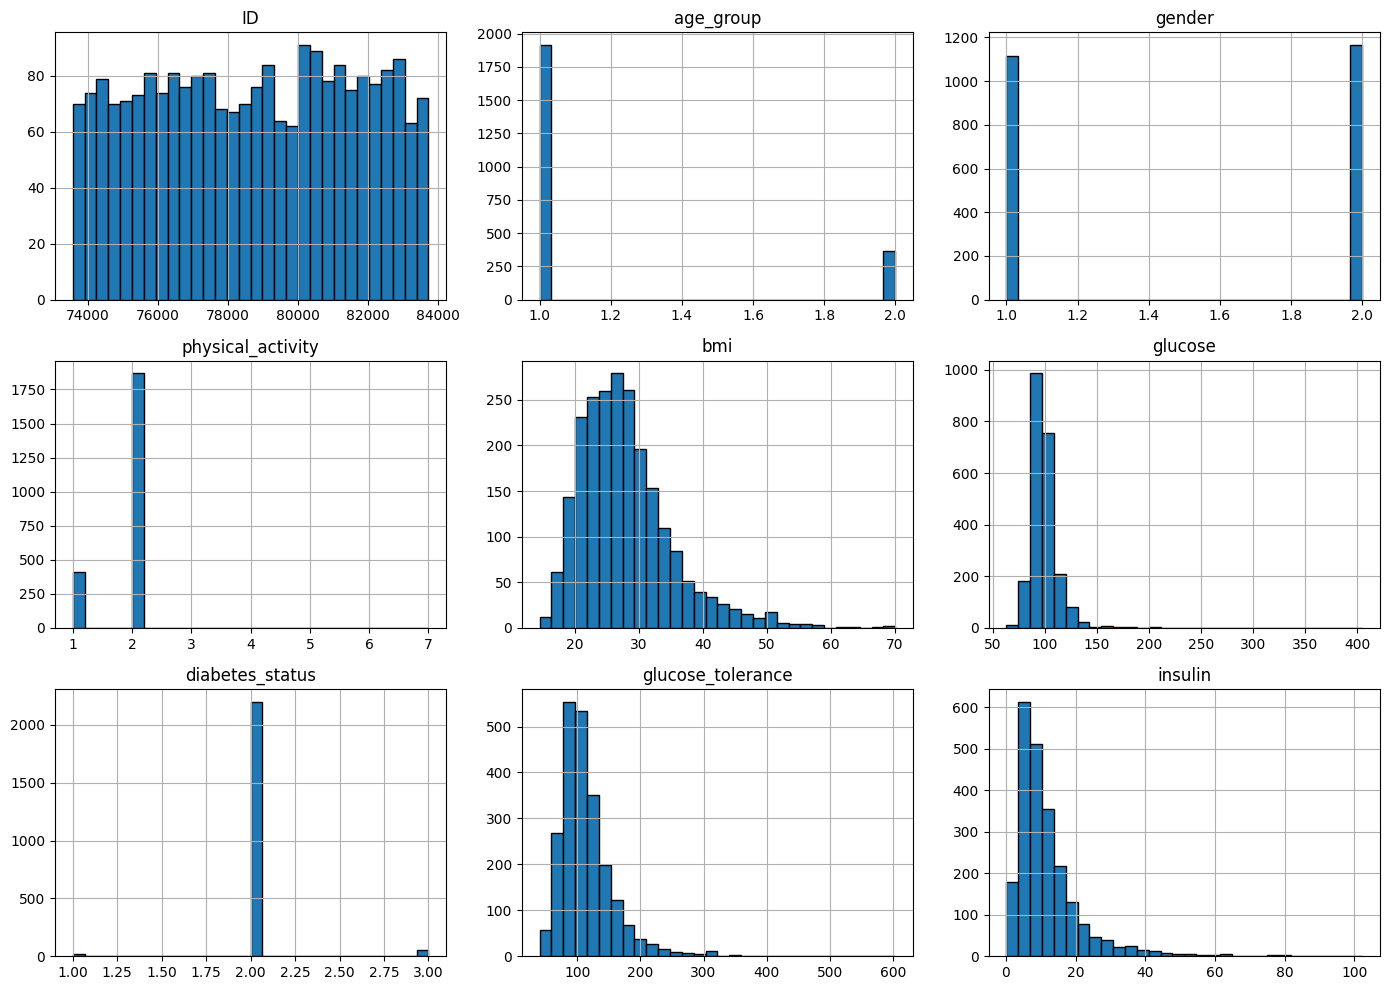

In [7]:
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

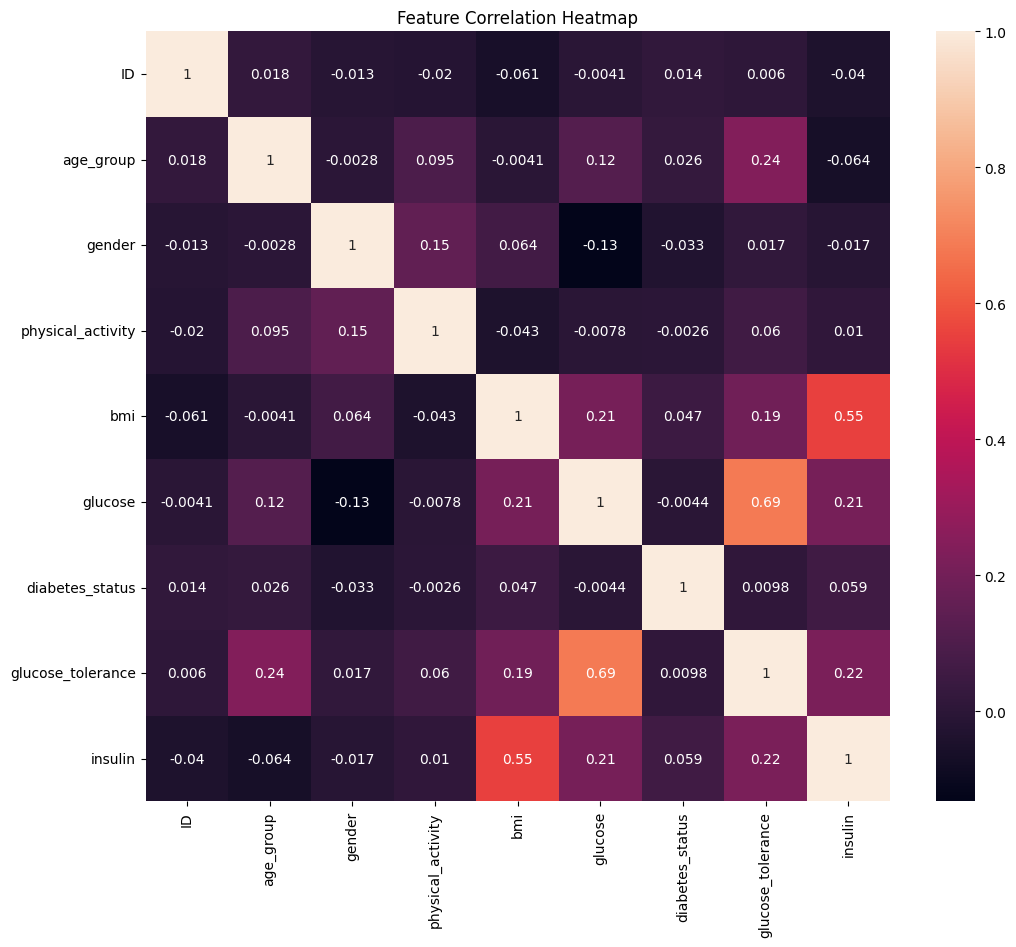

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

#### Cheking and removing outliers

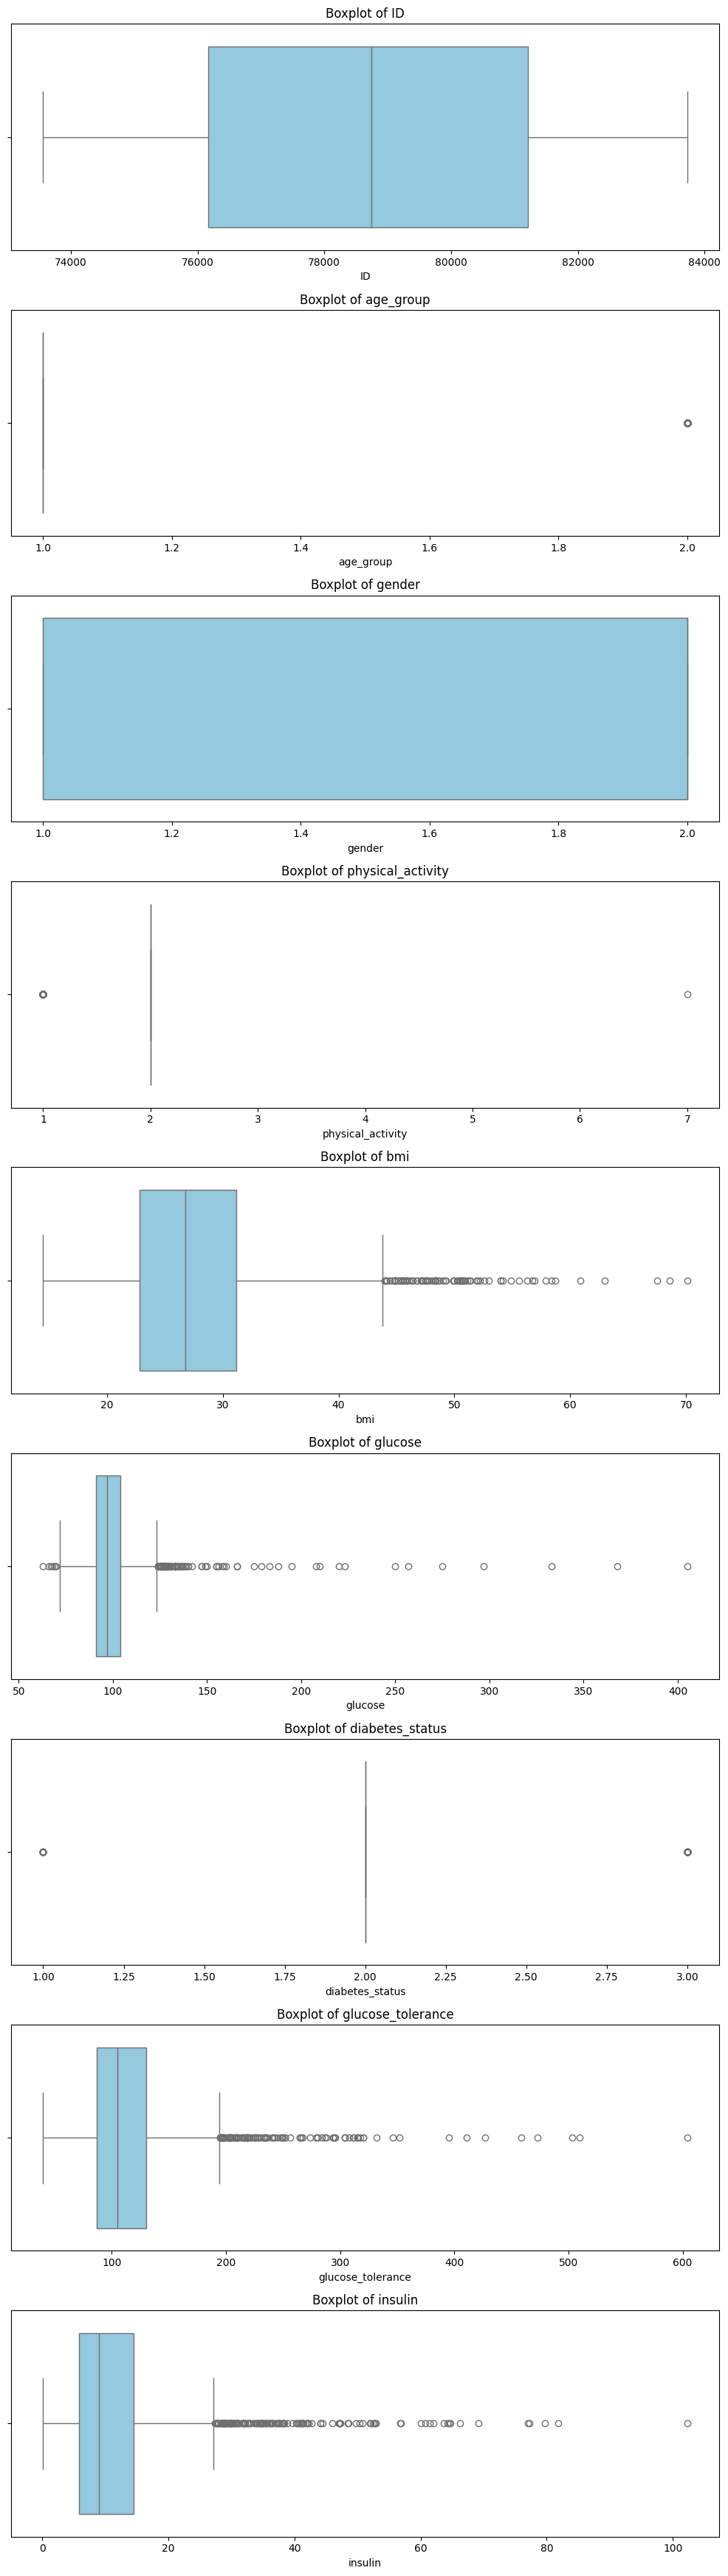

In [9]:
def check_outliers(df):
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 35))
    for i, col in enumerate(df.columns):
        sns.boxplot(x=df[col], ax=axs[i], color='skyblue')
        axs[i].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

check_outliers(df)

In [10]:
def drop_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

num_cols = df.select_dtypes(include=np.number).columns
df = drop_outliers(df, num_cols)

#### Data Scaling

In [11]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# Model training and evaluation

1. Take models and train on X_train, y_train
2. Predict age_group
3. Plot metrics like accuracy_score, confussion_matrix, etc.
4. Tune hyperparameters of the models using tune_parameters.

In [12]:
def checkForOutliers(df):
    fig, axs = plt.subplots(len(df.columns),1,dpi=95, figsize=(7,30))
    axs = np.atleast_1d(axs) 
    for i, col in enumerate(df.columns):
        axs[i].boxplot(df[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()

def dropOutliers(df, drop_list):
    for col in drop_list:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        clean_data = df[(df[col] > lower_bound) 
                        & (df[col] < upper_bound)]
        df = clean_data
    return df

# function to tune hyperparameters of a selected model
# how to write param_grid
param_grid = {
    'classification__penalty': ['l1', 'l2', 'elasticnet', None],
    'classification__max_iter': [100, 200, 500],
    'classification__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'classification__multi_class': ['auto', 'ovr', 'multinomial']
}

def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

def train_predict_evaluate(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=np.nan)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("\nModel:", str(model))
    print("| Accuracy score:", accuracy)
    print("| Precision score:", precision)
    print("| Recall score:", recall)
    print("| F1 score:", f1)
    print("| Confussion matrix:\n", cm)
    

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression(solver='liblinear')
train_predict_evaluate(model, X, y)


model = LogisticRegression(max_iter=200, solver='newton-cg')
train_predict_evaluate(model, X, y)

model = KNeighborsClassifier()
train_predict_evaluate(model, X, y) # cannot tune params


model = DecisionTreeClassifier(random_state=0)
train_predict_evaluate(model, X, y)

model = RandomForestClassifier(max_depth= 2, min_samples_split= 2, n_estimators= 100) # good enough
train_predict_evaluate(model, X, y)

model = SVC()
train_predict_evaluate(model, X, y) # cannot tune params

model = GaussianNB()
train_predict_evaluate(model, X, y) # cannot tune params

model = GradientBoostingClassifier(ccp_alpha= 0.01, loss= 'log_loss', max_depth= 2)
train_predict_evaluate(model, X, y) # good enough

# param_grid = {
#     'classification__loss': ['log_loss', 'deviance', 'exponential'],
#     'classification__max_depth': [2, 3, 4],
#     'classification__ccp_alpha': [0.01, 0.1, 1],
# }

# tune_hyperparams(model, param_grid, X_train, y_train)


Model: LogisticRegression(solver='liblinear')
| Accuracy score: 0.8333333333333334
| Precision score: 0.843400447427293
| Recall score: 0.9843342036553525
| F1 score: 0.908433734939759
| Confussion matrix:
 [[377   6]
 [ 70   3]]

Model: LogisticRegression(max_iter=200, solver='newton-cg')
| Accuracy score: 0.8442982456140351
| Precision score: 0.8513513513513513
| Recall score: 0.9869451697127938
| F1 score: 0.9141475211608222
| Confussion matrix:
 [[378   5]
 [ 66   7]]

Model: KNeighborsClassifier()
| Accuracy score: 0.8355263157894737
| Precision score: 0.8532110091743119
| Recall score: 0.9712793733681462
| F1 score: 0.9084249084249084
| Confussion matrix:
 [[372  11]
 [ 64   9]]

Model: DecisionTreeClassifier(random_state=0)
| Accuracy score: 0.7521929824561403
| Precision score: 0.875
| Recall score: 0.8224543080939948
| F1 score: 0.847913862718708
| Confussion matrix:
 [[315  68]
 [ 45  28]]

Model: RandomForestClassifier(max_depth=2)
| Accuracy score: 0.8399122807017544
| Pre

/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(



Model: GradientBoostingClassifier(ccp_alpha=0.01, max_depth=2)
| Accuracy score: 0.8399122807017544
| Precision score: 0.8399122807017544
| Recall score: 1.0
| F1 score: 0.9129916567342073
| Confussion matrix:
 [[383   0]
 [ 73   0]]


In [ ]:
models = {
    'Logistic Regression (liblinear)': LogisticRegression(solver='liblinear'),
    'Logistic Regression (newton-cg)': LogisticRegression(max_iter=200, solver='newton-cg'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(max_depth=2, min_samples_split=2, n_estimators=100),
    'GaussianNB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(ccp_alpha=0.01, loss='log_loss', max_depth=2)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    precision_c, recall_c, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, cv=5)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr, 
        'tpr': tpr,
        'roc_curve': roc_auc,
        'precision_curve': precision_c,
        'recall_curve': recall_c,
        'train_sizes':train_sizes,
        'train_scores':train_scores,
        'validation_scores': validation_scores
    }

metrics_df = pd.DataFrame(results).T
metrics_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
labels = ['-', 'True Negative (TN)', 'True Positive (TP)', '-']
for i, model_name in enumerate(models.keys()):
    cm = results[model_name]['confusion_matrix']
    cm_reshaped = cm.reshape(2, 2)
    sns.heatmap(cm_reshaped, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels[:2], yticklabels=labels[2:], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['roc_curve']
    axes[i].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i].set_title(f'Roc AUC: {model_name}')
    axes[i].set_xlabel('False positive rate')
    axes[i].set_ylabel('True positive rate')
    axes[i].legend(loc='lower right')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    recall = results[model_name]['recall_curve']
    precision = results[model_name]['precision_curve']
    axes[i].plot(recall, precision, color='red', lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {model_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    train_size = results[model_name]['train_sizes']
    train_scores = results[model_name]['train_scores']
    valid_scores = results[model_name]['validation_scores']
    param_range = np.arange(1, 10, 1)
    axes[i].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[i].plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation score')
    axes[i].set_title('Learning Curve')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('Score')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()




ValueError: y_true takes value in {1.0, 2.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.